In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #BERT+Attention head LSTM classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

# Veriyi yükleme
xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str)

# Etiketlerin encode edilmesi
label_encoder = LabelEncoder()
xt['label'] = label_encoder.fit_transform(xt['label'])

# BERT Tokenizer ve Modelin Yüklenmesi
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
bert_model = BertModel.from_pretrained('dbmdz/bert-base-turkish-cased')

# Özel Dataset sınıfı
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Veri setini hazırlama
max_len = 128
train_data, test_data = train_test_split(xt, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data['mesaj'].values, train_data['label'].values, tokenizer, max_len)
test_dataset = TextDataset(test_data['mesaj'].values, test_data['label'].values, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# LSTM Sınıflandırma modeli
class LSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.bert = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = outputs[0]
        _, (hidden, _) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# Model, optimizer ve loss fonksiyonu
hidden_dim = 256
output_dim = len(label_encoder.classes_)
n_layers = 2
bidirectional = True
dropout = 0.3

model = LSTMClassifier(bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Eğitim döngüsü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Eğitim ve değerlendirme
epochs = 3
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')  # Burada "epoch" yerine "epochs" kullanılmalı
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_data)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        test_loader,
        loss_fn,
        device,
        len(test_data)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print(f'Best validation accuracy: {best_accuracy}')

# Modelin test veri seti üzerinde değerlendirilmesi
model.load_state_dict(torch.load('best_model_state.bin'))
model.to(device)

test_acc, _ = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test accuracy: {test_acc}')

# Classification report
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for d in test_loader:  # Tüm test verisi üzerinde döngü
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
# Sınıf isimlerini al ve string'e çevir
target_names = label_encoder.classes_.astype(str).tolist()

# Classification report
print(classification_report(y_true, y_pred, target_names=target_names))

Epoch 1/3
----------
Train loss 0.40035503322218097 accuracy 0.8215013586956521
Val loss 0.2463373758740002 accuracy 0.9063136456211812
Epoch 2/3
----------
Train loss 0.22186877738441463 accuracy 0.9213654891304348
Val loss 0.24753430905321272 accuracy 0.9131025118805159
Epoch 3/3
----------
Train loss 0.1470788078909011 accuracy 0.9580502717391304
Val loss 0.3102127640728428 accuracy 0.9164969450101833
Best validation accuracy: 0.9164969450101833
Test accuracy: 0.9164969450101833
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       751
           1       0.94      0.89      0.91       722

    accuracy                           0.92      1473
   macro avg       0.92      0.92      0.92      1473
weighted avg       0.92      0.92      0.92      1473



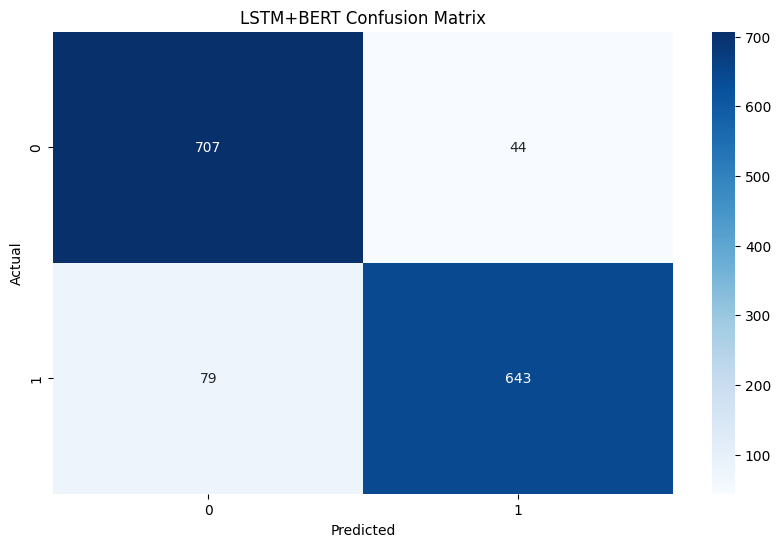

In [ ]:

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('LSTM+BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = message.lower()
    encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return label_encoder.inverse_transform(preds.cpu().numpy())[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): hayvan
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): merhaba güzel 
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): şerefsiz
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): hayır
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/3
----------
Train loss 0.37732592346551624 accuracy 0.8318614130434783
Val loss 0.21619714043473684 accuracy 0.9171758316361167
Epoch 2/3
----------
Train loss 0.1969897553132361 accuracy 0.9330842391304348
Val loss 0.28009179514902893 accuracy 0.9083503054989817
Epoch 3/3
----------
Train loss 0.13107180666765603 accuracy 0.9624660326086957
Val loss 0.39210216113696655 accuracy 0.9063136456211812
Best validation accuracy: 0.9171758316361167
Test accuracy: 0.9171758316361167
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       751
           1       0.91      0.92      0.92       722

    accuracy                           0.92      1473
   macro avg       0.92      0.92      0.92      1473
weighted avg       0.92      0.92      0.92      1473



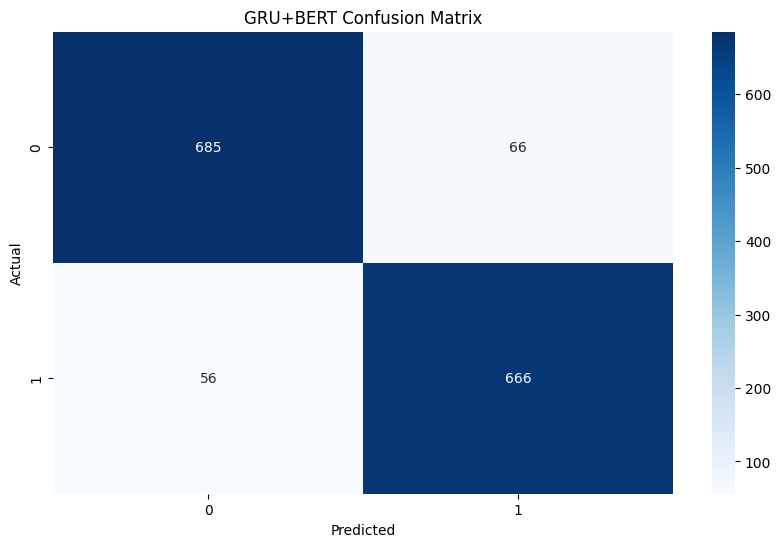

In [ ]:
#BERT+Attention head GRU classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt

# Veriyi yükleme
xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str)

# Etiketlerin encode edilmesi
label_encoder = LabelEncoder()
xt['label'] = label_encoder.fit_transform(xt['label'])

# BERT Tokenizer ve Modelin Yüklenmesi
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
bert_model = BertModel.from_pretrained('dbmdz/bert-base-turkish-cased')

# Özel Dataset sınıfı
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Veri setini hazırlama
max_len = 128
train_data, test_data = train_test_split(xt, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data['mesaj'].values, train_data['label'].values, tokenizer, max_len)
test_dataset = TextDataset(test_data['mesaj'].values, test_data['label'].values, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# GRU Sınıflandırma modeli
class GRUClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.bert = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.rnn1 = nn.GRU(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        self.attention = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.rnn2 = nn.GRU(hidden_dim,
                           hidden_dim // 2,
                           num_layers=1,
                           bidirectional=False,
                           dropout=dropout,
                           batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = outputs[0]
        rnn1_output, _ = self.rnn1(embedded)
        attention_output = self.attention(rnn1_output)
        attention_output = self.dropout1(attention_output)
        rnn2_output, _ = self.rnn2(attention_output)
        rnn2_output = self.dropout2(rnn2_output)
        output = self.fc(rnn2_output[:, -1, :])
        return output

# Model, optimizer ve loss fonksiyonu
hidden_dim = 256
output_dim = len(label_encoder.classes_)
n_layers = 2
bidirectional = True
dropout = 0.3

model = GRUClassifier(bert_model, hidden_dim, output_dim, n_layers, bidirectional, dropout)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Eğitim döngüsü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Eğitim ve değerlendirme
epochs = 3
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_data)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        test_loader,
        loss_fn,
        device,
        len(test_data)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print(f'Best validation accuracy: {best_accuracy}')

# Modelin test veri seti üzerinde değerlendirilmesi
model.load_state_dict(torch.load('best_model_state.bin'))
model.to(device)

test_acc, _ = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test accuracy: {test_acc}')

# Classification report
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for d in test_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Sınıf isimlerini al ve string'e çevir
target_names = label_encoder.classes_.astype(str).tolist()

# Classification report
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('GRU+BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = message.lower()
    encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return label_encoder.inverse_transform(preds.cpu().numpy())[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): salak
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): güzel bir gün
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): manyak
Çıkış yapılıyor...


Epoch 1/3
----------
Train loss 0.3905615613127694 accuracy 0.8381453804347826
Val loss 0.23865108400262813 accuracy 0.9083503054989817
Epoch 2/3
----------
Train loss 0.22861636457357393 accuracy 0.9237432065217391
Val loss 0.24942453155013664 accuracy 0.9083503054989817
Epoch 3/3
----------
Train loss 0.15694651815283578 accuracy 0.9573709239130435
Val loss 0.34682555610228893 accuracy 0.9097080787508486
Best validation accuracy: 0.9097080787508486
Test accuracy: 0.9097080787508486
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       751
           1       0.88      0.94      0.91       722

    accuracy                           0.91      1473
   macro avg       0.91      0.91      0.91      1473
weighted avg       0.91      0.91      0.91      1473



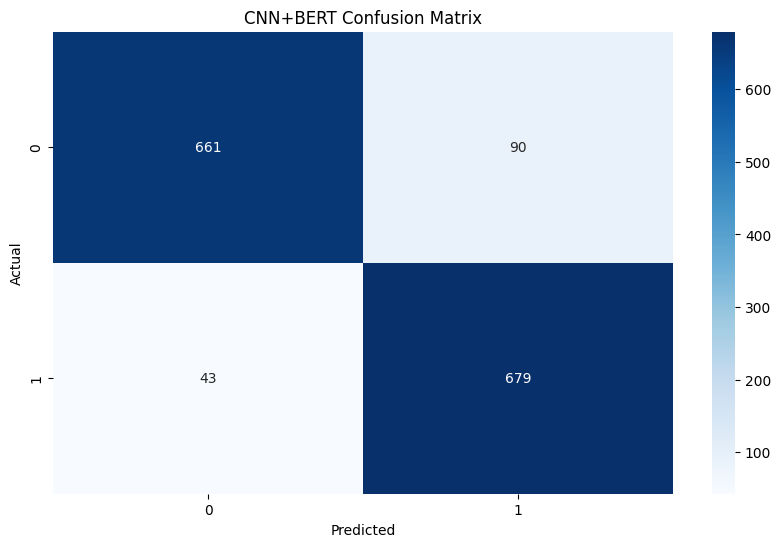

In [ ]:
#BERT+Attention head CNN classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt

# Veriyi yükleme
xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str)

# Etiketlerin encode edilmesi
label_encoder = LabelEncoder()
xt['label'] = label_encoder.fit_transform(xt['label'])

# BERT Tokenizer ve Modelin Yüklenmesi
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
bert_model = BertModel.from_pretrained('dbmdz/bert-base-turkish-cased')

# Özel Dataset sınıfı
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Veri setini hazırlama
max_len = 128
train_data, test_data = train_test_split(xt, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data['mesaj'].values, train_data['label'].values, tokenizer, max_len)
test_dataset = TextDataset(test_data['mesaj'].values, test_data['label'].values, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# CNN Sınıflandırma modeli
class CNNClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, dropout):
        super().__init__()
        self.bert = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=5)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5)
        self.max_pool2 = nn.MaxPool1d(kernel_size=2)
        self.self_attention = nn.MultiheadAttention(embed_dim=64, num_heads=8, dropout=dropout)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = outputs[0].permute(0, 2, 1)
        x = self.conv1(embedded)
        x = torch.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.max_pool2(x)
        x = x.permute(2, 0, 1)  # seq_len, batch, embedding_dim for attention
        attn_output, _ = self.self_attention(x, x, x)
        attn_output = attn_output.permute(1, 2, 0)  # batch, embedding_dim, seq_len
        x = self.global_max_pool(attn_output).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# Model, optimizer ve loss fonksiyonu
hidden_dim = 256
output_dim = len(label_encoder.classes_)
dropout = 0.3

model = CNNClassifier(bert_model, hidden_dim, output_dim, dropout)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Eğitim döngüsü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Eğitim ve değerlendirme
epochs = 3
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_data)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        test_loader,
        loss_fn,
        device,
        len(test_data)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print(f'Best validation accuracy: {best_accuracy}')

# Modelin test veri seti üzerinde değerlendirilmesi
model.load_state_dict(torch.load('best_model_state.bin'))
model.to(device)

test_acc, _ = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test accuracy: {test_acc}')

# Classification report
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for d in test_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Sınıf isimlerini al ve string'e çevir
target_names = label_encoder.classes_.astype(str).tolist()

# Classification report
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('CNN+BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = message.lower()
    encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return label_encoder.inverse_transform(preds.cpu().numpy())[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): salak
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): güzel bir gün
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): köpek
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): hayır
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/3
----------
Train loss 0.4006573858508921 accuracy 0.8271059782608695
Val loss 0.23885712013529833 accuracy 0.9131025118805159
Epoch 2/3
----------
Train loss 0.2275973301299888 accuracy 0.9242527173913043
Val loss 0.23578918440848268 accuracy 0.9205702647657841
Epoch 3/3
----------
Train loss 0.15839670756173765 accuracy 0.9548233695652174
Val loss 0.3624376858514483 accuracy 0.9049558723693143
Best validation accuracy: 0.9205702647657841
Test accuracy: 0.9205702647657841
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       751
           1       0.91      0.93      0.92       722

    accuracy                           0.92      1473
   macro avg       0.92      0.92      0.92      1473
weighted avg       0.92      0.92      0.92      1473



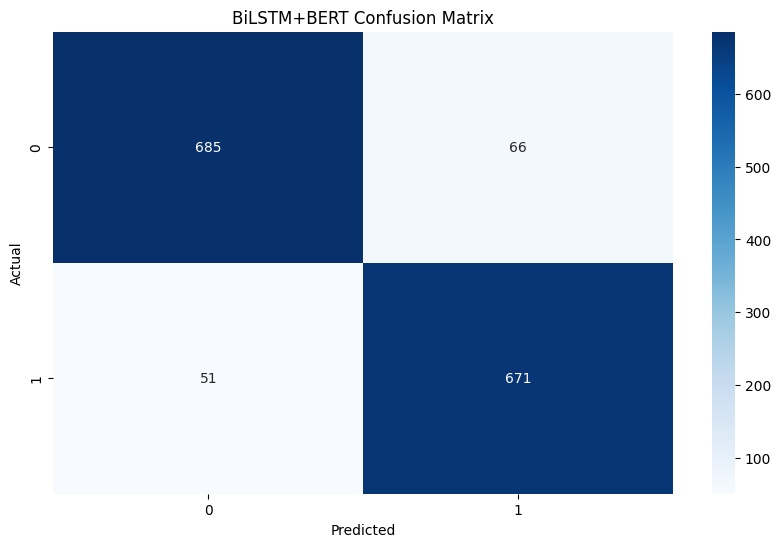

In [ ]:
#BERT+Attention head CNN classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt

# Veriyi yükleme
xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str)

# Etiketlerin encode edilmesi
label_encoder = LabelEncoder()
xt['label'] = label_encoder.fit_transform(xt['label'])

# BERT Tokenizer ve Modelin Yüklenmesi
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
bert_model = BertModel.from_pretrained('dbmdz/bert-base-turkish-cased')

# Özel Dataset sınıfı
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Veri setini hazırlama
max_len = 128
train_data, test_data = train_test_split(xt, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data['mesaj'].values, train_data['label'].values, tokenizer, max_len)
test_dataset = TextDataset(test_data['mesaj'].values, test_data['label'].values, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# BiLSTM Sınıflandırma modeli
class BiLSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, dropout):
        super().__init__()
        self.bert = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']

        # BiLSTM katmanları
        self.rnn1 = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=1,
                            bidirectional=True,  # BiLSTM
                            dropout=dropout,
                            batch_first=True)

        self.self_attention = nn.MultiheadAttention(embedding_dim, num_heads=8, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

        self.rnn2 = nn.LSTM(hidden_dim * 2,  # BiLSTM için çarpan 2
                            hidden_dim,
                            num_layers=1,
                            bidirectional=True,  # BiLSTM
                            dropout=dropout,
                            batch_first=True)

        self.dropout2 = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # BiLSTM için çarpan 2

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = outputs[0]

        # İlk BiLSTM katmanı
        lstm_out1, _ = self.rnn1(embedded)
        lstm_out1 = self.dropout1(lstm_out1)

        # İkinci BiLSTM katmanı
        lstm_out2, _ = self.rnn2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        # Sonuçları birleştirip çıkış katmanına gönder
        return self.fc(lstm_out2[:, -1, :])  # Son zaman adımını al

# Model, optimizer ve loss fonksiyonu
hidden_dim = 256
output_dim = len(label_encoder.classes_)
dropout = 0.3

model = BiLSTMClassifier(bert_model, hidden_dim, output_dim, dropout)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Eğitim döngüsü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Eğitim ve değerlendirme
epochs = 3
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_data)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        test_loader,
        loss_fn,
        device,
        len(test_data)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print(f'Best validation accuracy: {best_accuracy}')

# Modelin test veri seti üzerinde değerlendirilmesi
model.load_state_dict(torch.load('best_model_state.bin'))
model.to(device)

test_acc, _ = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_data)
)

print(f'Test accuracy: {test_acc}')

# Classification report
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for d in test_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Sınıf isimlerini al ve string'e çevir
target_names = label_encoder.classes_.astype(str).tolist()

# Classification report
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('BiLSTM+BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = message.lower()
    encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return label_encoder.inverse_transform(preds.cpu().numpy())[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): merhaba
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ne güzel bir gün
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): manyak
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): dallama
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): yavşak
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): sarı çiçek
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): hayır
Çıkış yapılıyor...
